In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import torch

from skimage import io

%matplotlib inline

In [2]:
from utils import adjust_sar_contrast, compute_building_score, plot_images

sys.path.append('..')
from spacenet6_model.configs.defaults import get_default_config
from spacenet6_model.datasets.utils import lookup_orientation, read_orientation_file
from spacenet6_model.models import get_model
from spacenet6_model.transforms.preprocesses import _to_tensor, _normalize_image

In [3]:
# set hyper parameters and path to model weight
exp = 'exp_0064'
config_path = f'/logs/{exp}/config.yml'
weight_path = f'/weights/{exp}/model_best.pth'

# select device to which the model is loaded
cuda = False
if cuda:
    device = 'cuda'
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
else:
    device = 'cpu'
    os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [4]:
config = get_default_config()

# overwtite from the config file
config.merge_from_file(config_path)

# overwrite model weight and device
config.MODEL.WEIGHT = weight_path
config.MODEL.DEVICE = device

config.freeze()
print(config)

DATALOADER:
  TRAIN_BATCH_SIZE: 24
  TRAIN_NUM_WORKERS: 8
  TRAIN_SHUFFLE: True
  VAL_BATCH_SIZE: 16
  VAL_NUM_WORKERS: 8
EVAL:
  MAIN_METRIC: iou/building_footprint
  METRICS: ['iou']
EXP_ID: 64
INPUT:
  BUILDING_DIR: /data/spacenet6/footprint_boundary_mask/v_01/labels
  CLASSES: ['building_footprint', 'building_boundary']
  IMAGE_DIR: /data/spacenet6/spacenet6/train
  IMAGE_TYPE: SAR-Intensity
  MEAN_STD_DIR: /data/spacenet6/image_mean_std/
  SAR_ORIENTATION: /data/spacenet6/spacenet6/train/SummaryData/SAR_orientations.txt
  TRAIN_VAL_SPLIT_DIR: /data/spacenet6/split
  TRAIN_VAL_SPLIT_ID: 3
LOG_ROOT: /logs
MODEL:
  ACTIVATION: sigmoid
  ARCHITECTURE: unet
  BACKBONE: efficientnet-b5
  DEVICE: cpu
  ENCODER_PRETRAINED_FROM: imagenet
  IN_CHANNELS: 4
  WEIGHT: /weights/exp_0064/model_best.pth
SOLVER:
  EPOCHS: 260
  FOCAL_LOSS_GAMMA: 2.0
  LOSSES: ['dice', 'bce']
  LOSS_WEIGHTS: [1.0, 1.0]
  LR: 0.0001
  LR_ANNEALING_ETA_MIN: 0.0
  LR_ANNEALING_T_MAX: 260
  LR_MULTISTEP_GAMMA: 0.1
  LR

In [5]:
model = get_model(config)
model.eval();

In [6]:
test_sar_dir = '/data/spacenet6/spacenet6/test_public/SAR-Intensity'
test_sar_fnames = os.listdir(test_sar_dir)
test_sar_fnames.sort()

In [7]:
channel_footprint = config.INPUT.CLASSES.index('building_footprint')
channel_boundary = config.INPUT.CLASSES.index('building_boundary')

In [8]:
mean_path = os.path.join(
    config.INPUT.MEAN_STD_DIR,
    config.INPUT.IMAGE_TYPE,
    'mean.npy'
)
mean = np.load(mean_path)
mean = mean[np.newaxis, np.newaxis, :]

std_path = os.path.join(
    config.INPUT.MEAN_STD_DIR,
    config.INPUT.IMAGE_TYPE,
    'std.npy'
)
std = np.load(std_path)
std = std[np.newaxis, np.newaxis, :]

In [9]:
orientation_df = read_orientation_file(config.INPUT.SAR_ORIENTATION)

In [10]:
def compute_pads(dst_wh, src_wh):
    dst_w, dst_h = dst_wh
    src_w, src_h = src_wh
    assert dst_w >= src_w
    assert dst_h >= dst_h
    
    pad_left = (dst_w - src_w) // 2
    pad_right = dst_w - pad_left - src_w
    pad_top = (dst_h - src_h) // 2
    pad_bottom = dst_h - pad_top - src_h
    
    return (pad_left, pad_right), (pad_top, pad_bottom)

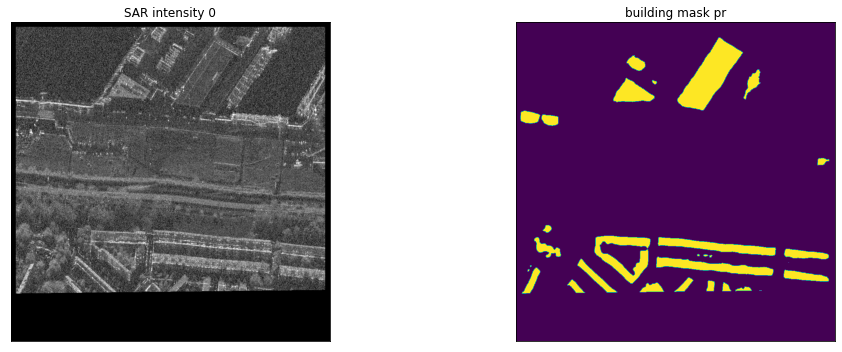

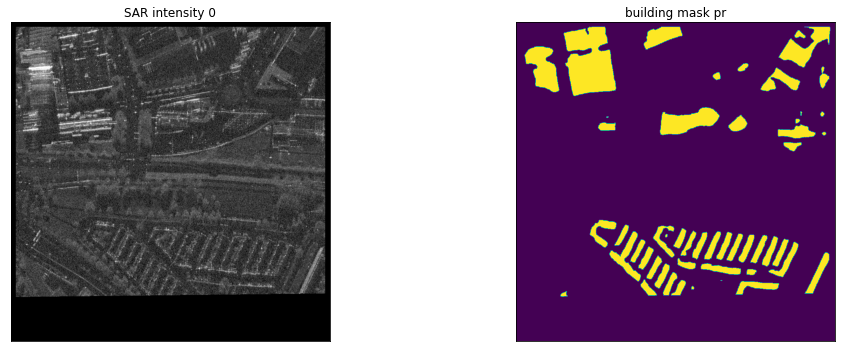

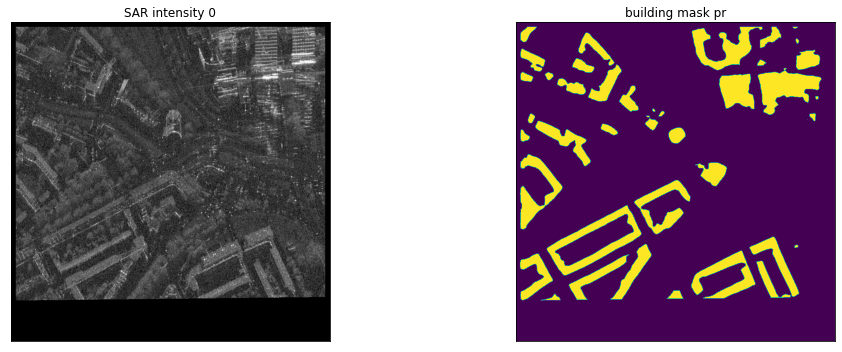

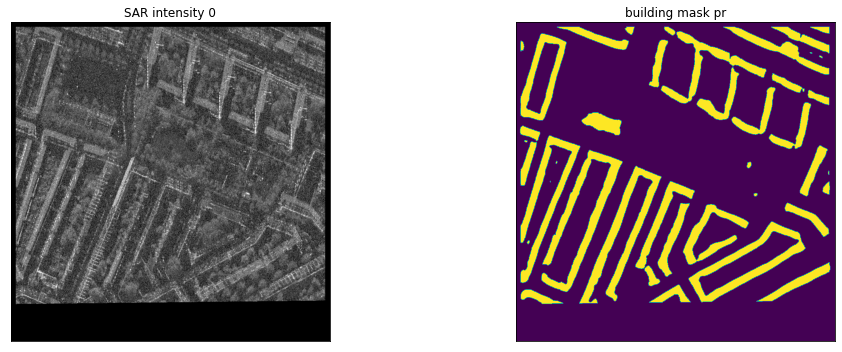

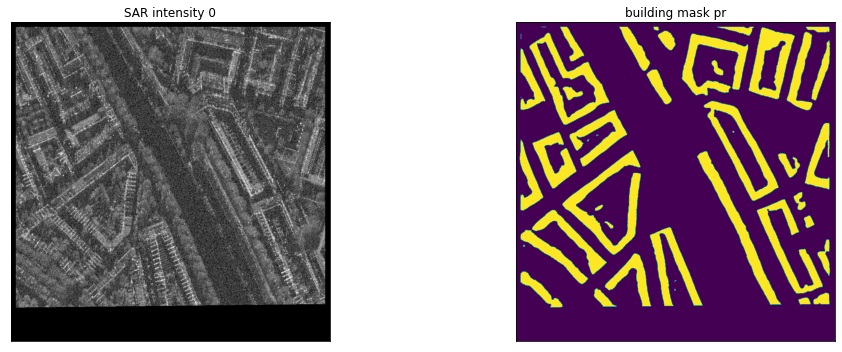

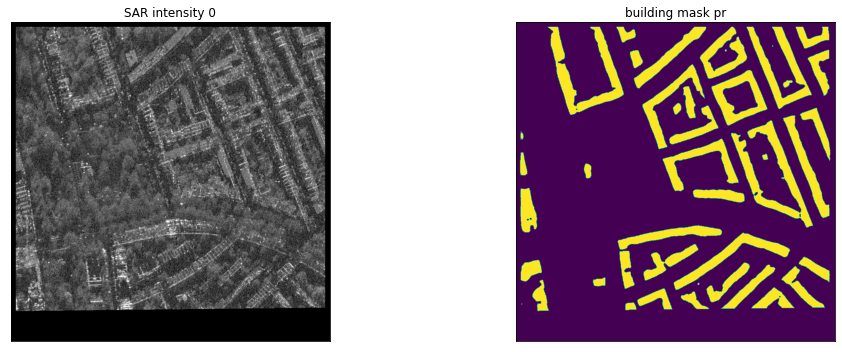

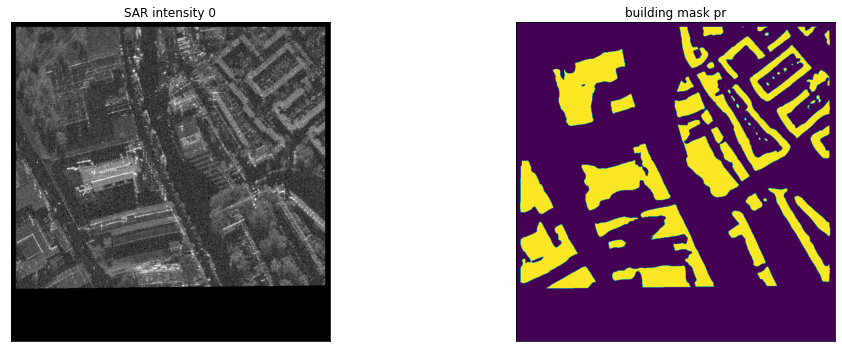

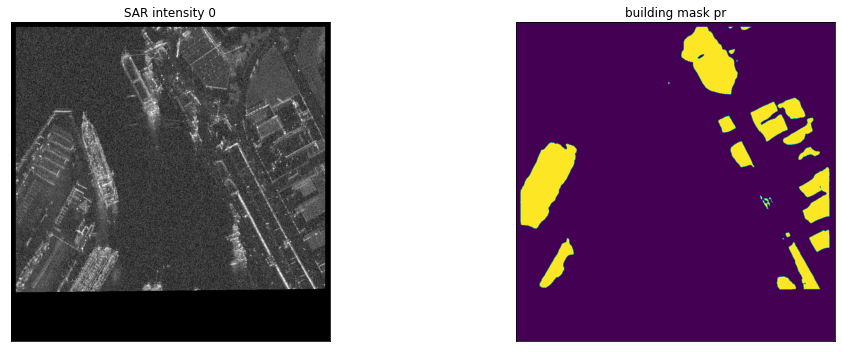

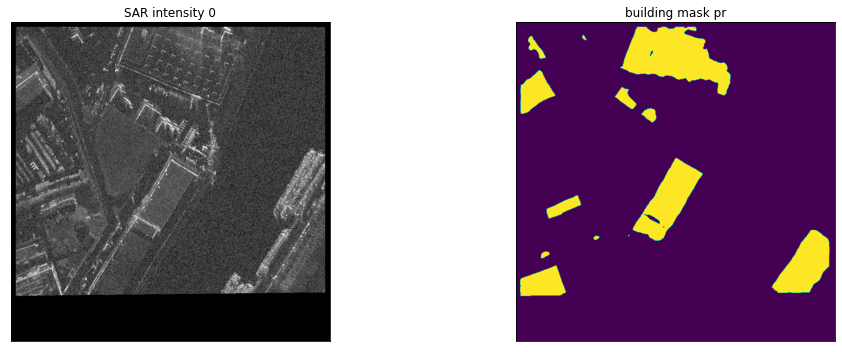

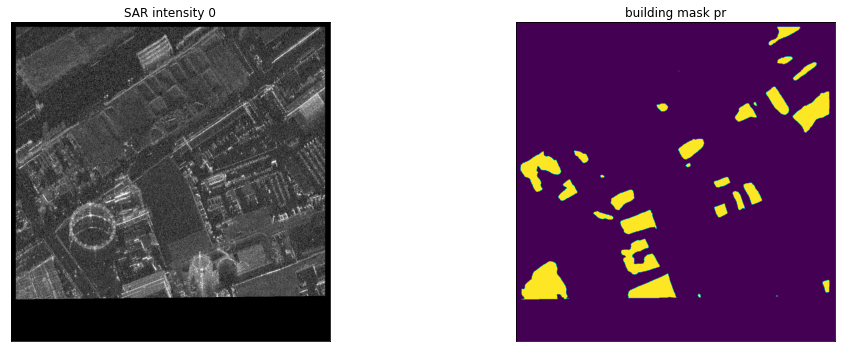

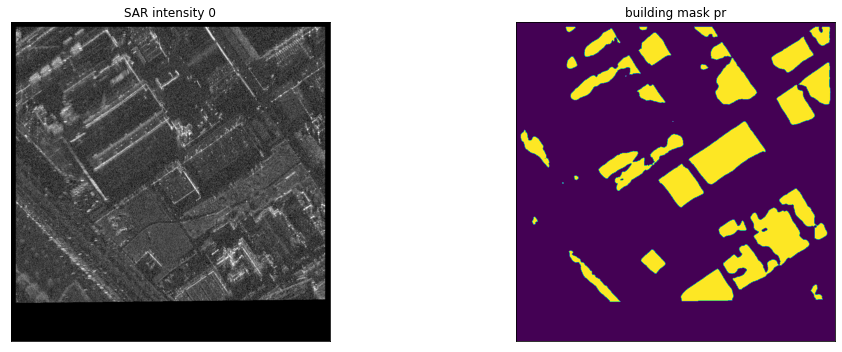

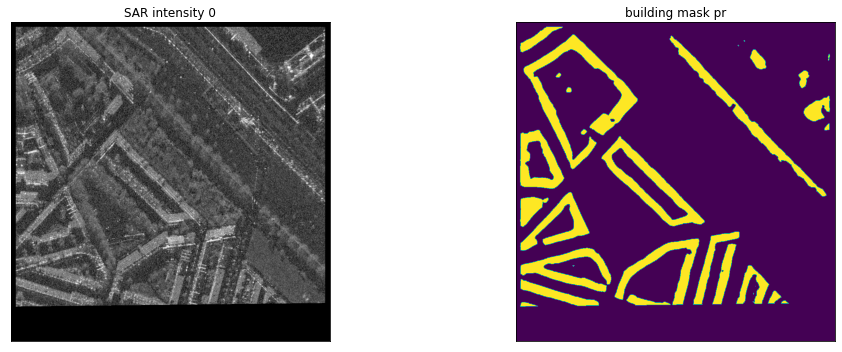

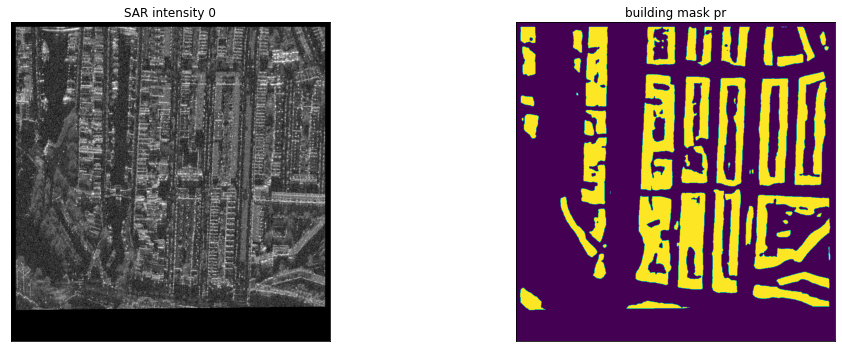

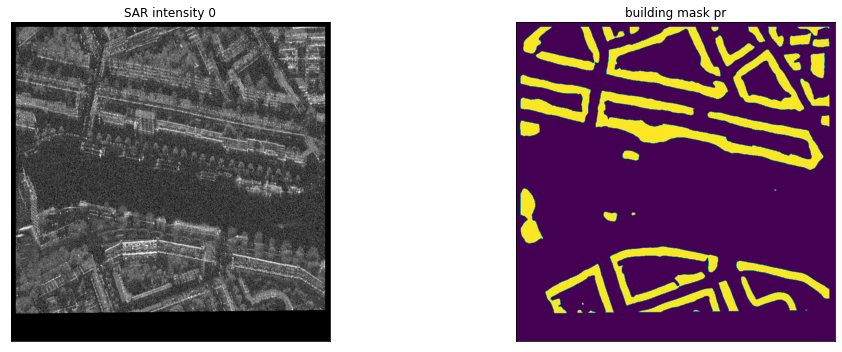

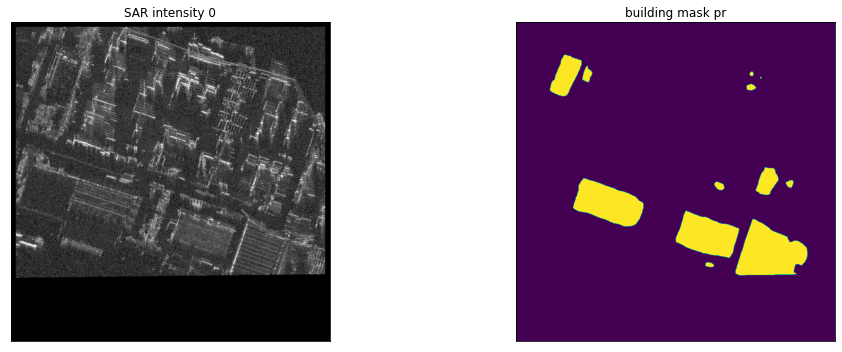

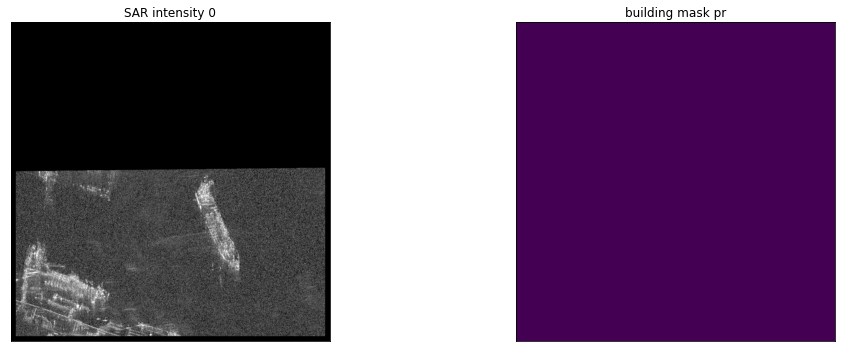

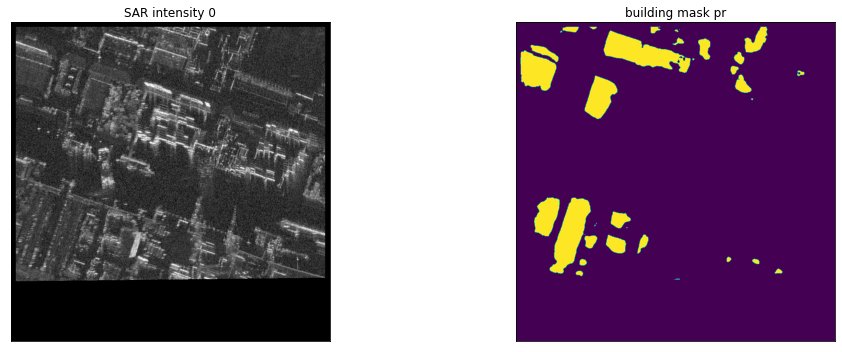

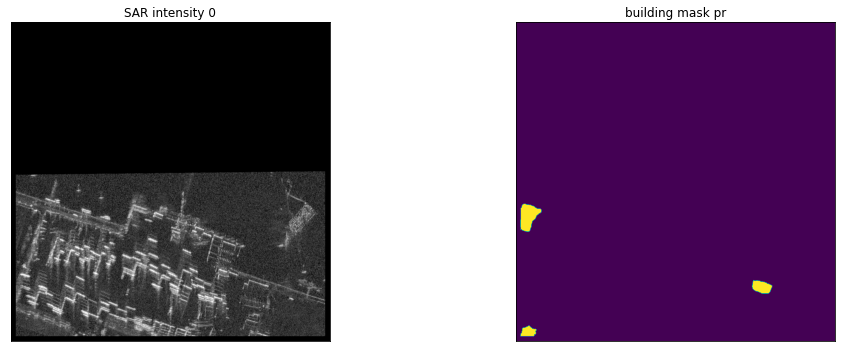

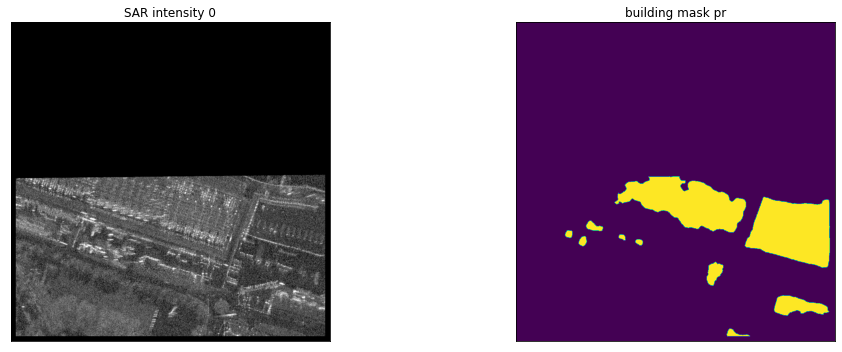

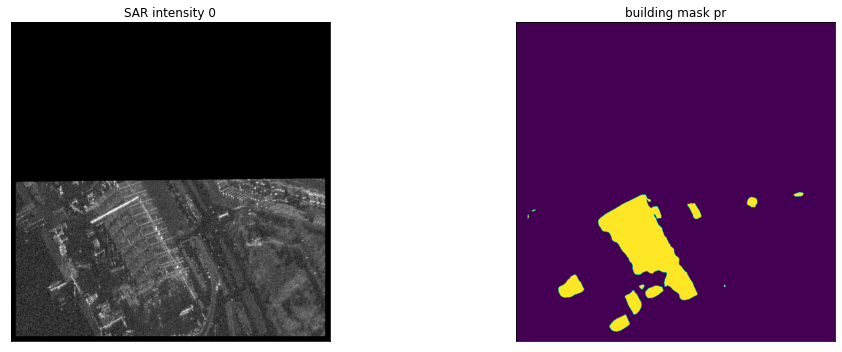

In [11]:
score_thresh = 0.5
alpha = 1.0

start_index = 310
N = 20

for i in range(start_index, start_index + N):
    test_sar_path = os.path.join(test_sar_dir, test_sar_fnames[i])
    test_image = io.imread(test_sar_path)
    
    if config.TRANSFORM.ALIGN_SAR_ORIENTATION:
        # align orientation to north
        orientation = lookup_orientation(test_sar_path, orientation_df)
        if orientation != config.TRANSFORM.TARGET_SAR_ORIENTATION:
            test_image = np.fliplr(np.flipud(test_image))

    h, w, _ = test_image.shape
    pad_widths, pad_heights = compute_pads(
        dst_wh=config.TRANSFORM.TEST_SIZE,
        src_wh=(w, h)
    )
    test_image = np.pad(test_image, (pad_heights, pad_widths, (0, 0)), mode='constant')
    
    x_tensor = test_image.copy()
    x_tensor = _normalize_image(x_tensor, mean, std)
    x_tensor = _to_tensor(x_tensor)
    x_tensor = torch.from_numpy(x_tensor).to(config.MODEL.DEVICE).unsqueeze(0)

    pr_score = model.module.predict(x_tensor)
    pr_score = pr_score.squeeze()
    pr_score = (pr_score.squeeze().cpu().numpy())
    
    pr_score_building = compute_building_score(
        pr_score[channel_footprint],
        pr_score[channel_boundary],
        alpha=alpha
    )
    pr_mask = pr_score_building > score_thresh
    
    plot_images(
        SAR_intensity_0=(adjust_sar_contrast(test_image[:, :, 0]), 'gray'),
        building_mask_pr=(pr_mask, 'viridis')
    )